In [1]:
%matplotlib notebook
import netCDF4
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'default_rename.set'
argv2 = r'paths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2001-12-31 00:00:00
730


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2CMF2DFM/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30minPCR2CMF2DFM/
/home/ikeuchi/Share/GLOFRIM/glofrim


## create PCR model BMI object

In [5]:
PCR_config_fn = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')
print(PCR_in_dir)
print(PCR_config_fn)
print(PCR_out_dir)

PCR_bmi = PCR_model(PCR_config_fn, PCR_in_dir, PCR_out_dir,
                            start_date, end_date,)

/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/PCR_Elbe/input30min
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe.ini
/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30minPCR2CMF2DFM/PCR


## create CMF model BMI object

In [6]:
CMF_engine = os.path.join(cwd, options['CMF_engine']['CMF_path'])
print(CMF_engine)
CMF_model_dir = os.path.join(cwd, options['routing_model']['model_dir'])
CMF_config_fn = os.path.join(CMF_model_dir, options['routing_model']['model_file'])
CMF_out_dir = os.path.join(out_dir, 'CMF')
     
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date, dt=86400)


/home/ikeuchi/Share/GLOFRIM/glofrim/cama-flood_bmi/src/libcama.so


## create DFM model BMI object

In [7]:
DFM_engine = os.path.join(cwd, options['DFM_engine']['DFM_path'])
DFM_model_dir = os.path.join(cwd, options['hydrodynamic_model']['model_dir'])
DFM_config_fn = os.path.join(DFM_model_dir, options['hydrodynamic_model']['model_file'])
DFM_out_dir = os.path.join(out_dir, 'DFM')
print(DFM_engine)
print(DFM_model_dir)
print(DFM_config_fn)
print(DFM_out_dir)


DFM_bmi = DFM_model(DFM_engine, DFM_config_fn, DFM_model_dir, DFM_out_dir,
                              start_date, end_date, dt=86400.)

/home/ikeuchi/Share/DFLOW-FM/dflowfm-1.1.267/lib/libdflowfm.so
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/DFM_Elbe/delta/
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/DFM_Elbe/delta/DFM_Elbe_VU.mdu
/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30minPCR2CMF2DFM/DFM


## intitialize DFM model

In [8]:
# initialize DFM first to expose model coordinates via BMI
DFM_bmi.initialize()

## couple grids based on CMF inpmat file

In [9]:
# couple grids
PCR_bmi.couple_grid_to_grid(CMF_bmi)

## couple CMF to DFM based on 1d DFM indices

Couple external 1d coordinates to internal model 2d grid. 

From the green cells with value 1 (green) runoff is couled for the cells with value 2 (yellow) discharge is coupled

In [10]:
# get coupled dictionaries
CMF_bmi.couple_grid_to_1d(DFM_bmi)


In [11]:
np.where(CMF_bmi.coupled_mask > 1)

(array([5, 5, 5, 5, 6, 6, 6, 7, 7, 9]),
 array([12, 13, 15, 16, 11, 17, 18, 12, 20, 19]))

<IPython.core.display.Javascript object>


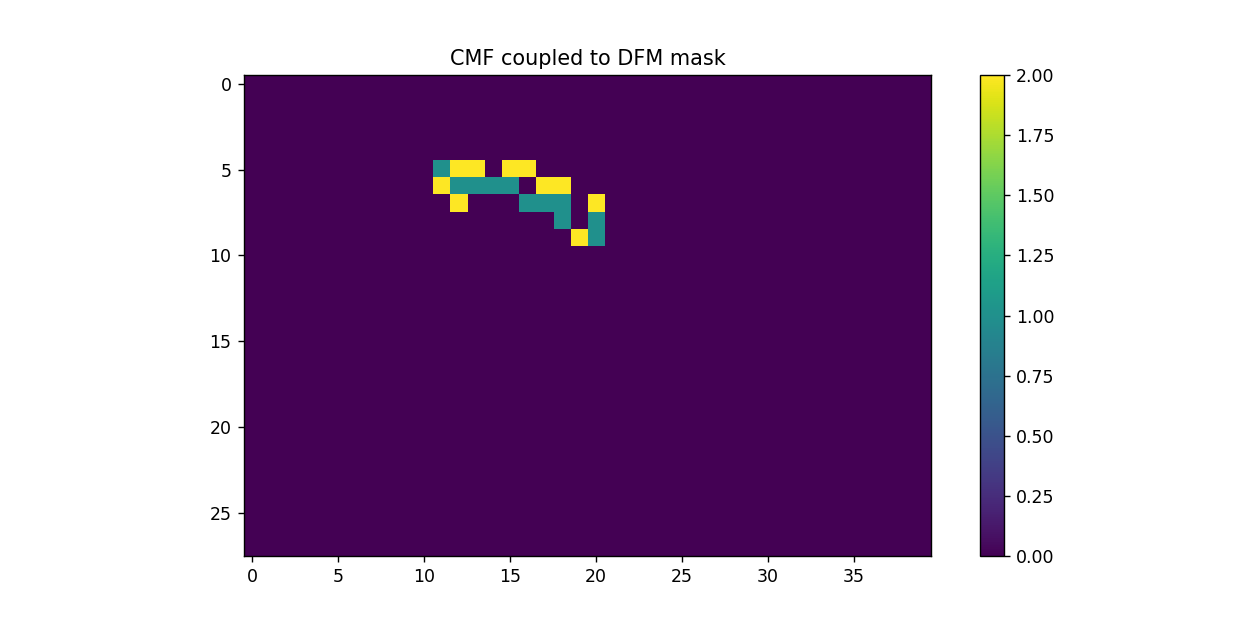

Text(0.5,1,u'CMF coupled to DFM mask')

In [12]:
fig = plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(CMF_bmi.coupled_mask, vmin=0, vmax=2)
#plt.imshow(np.ma.masked_less(CMF_bmi.upstream_matrix, 0))
plt.colorbar()
b.set_title('CMF coupled to DFM mask')
